In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from IPython.display import clear_output

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Młody\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
EPOCHS = 100
BATCH_SIZE = 32

In [5]:
data = pd.read_csv("./news.csv")
len(data)

6335

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [7]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [8]:
# label FAKE == 0 not true 
# label REAL == 1 true
data['label'][data["label"] == "FAKE"] = 0
data['label'][data["label"] == "REAL"] = 1

C:\Users\Młody\AppData\Local\Temp\ipykernel_4312\3025127627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'][data["label"] == "FAKE"] = 0
C:\Users\Młody\AppData\Local\Temp\ipykernel_4312\3025127627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'][data["label"] == "REAL"] = 1


In [9]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


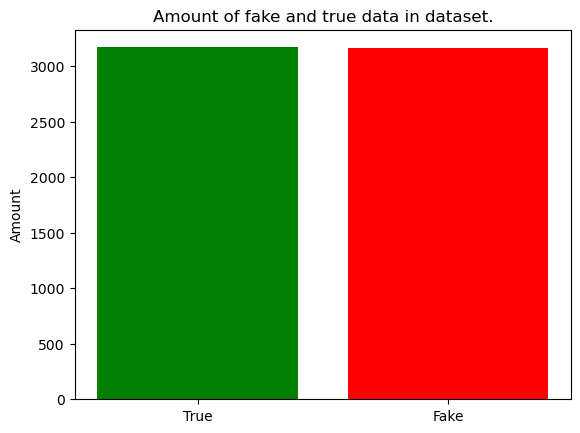

In [10]:
fig, ax = plt.subplots()

labels = ["True", "Fake"]
counts = [len(data['label'][data["label"] == 1]), len(data['label'][data["label"] == 0])]

ax.bar(labels, counts, color=["green", "red"])

ax.set_title("Amount of fake and true data in dataset.")
ax.set_ylabel("Amount")
plt.show()

In [11]:
def prepare_data(data):
    stpwords = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    for i in range(len(data)):
        prepared_text = " ".join([lemmatizer.lemmatize(word.lower()) for word in data.iloc[i]['text'].split(" ") if word not in stpwords])
        prepared_title = " ".join([lemmatizer.lemmatize(word.lower()) for word in data.iloc[i]['title'].split(" ") if word not in stpwords])
        data.at[i, 'doc'] = prepared_title + prepared_text
        clear_output(wait=True)
        print(i)

prepare_data(data)

6334


In [12]:
X, y = data.drop(["label", 'text', 'title'], axis=1), data['label']
X.head(), y.head()

(   Unnamed: 0                                                doc
 0        8476  you can smell hillary’s feardaniel greenfield,...
 1       10294  watch the exact moment paul ryan committed pol...
 2        3608  kerry go paris gesture sympathyu.s. secretary ...
 3       10142  bernie supporter twitter erupt anger dnc: 'we ...
 4         875  the battle new york: why this primary matterit...,
 0    0
 1    0
 2    1
 3    0
 4    1
 Name: label, dtype: object)

In [13]:
X.drop("Unnamed: 0", axis=1, inplace=True)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
X_train = X_train["doc"].tolist()
X_test = X_test["doc"].tolist()

In [15]:
vectorizer = TfidfVectorizer(max_features=7000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [16]:
class Dataset(Dataset):
    def __init__(self, X, y):
        self.x = X
        self.y = np.array(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [17]:
training_set = Dataset(X_train, Y_train)
valid_set = Dataset(X_test, Y_test)
training_iterator = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
X = next(iter(training_iterator))

In [19]:
X[0].dtype

torch.float64

In [20]:
class PredictionModel(nn.Module):
    def __init__(self):
        super(PredictionModel, self).__init__()
        self.md = nn.Sequential(
            nn.Linear(7000, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.to(torch.double)

        return self.md(x)

In [21]:
model = PredictionModel()
model.double()
model.to(device)

PredictionModel(
  (md): Sequential(
    (0): Linear(in_features=7000, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=16, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [22]:
model_dtype = next(model.parameters()).dtype
print(f"Model Data Type: {model_dtype}")

Model Data Type: torch.float64


In [23]:
output = model(X[0].to(device))
output

tensor([[0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515],
        [0.4515]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)

In [24]:
model_optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

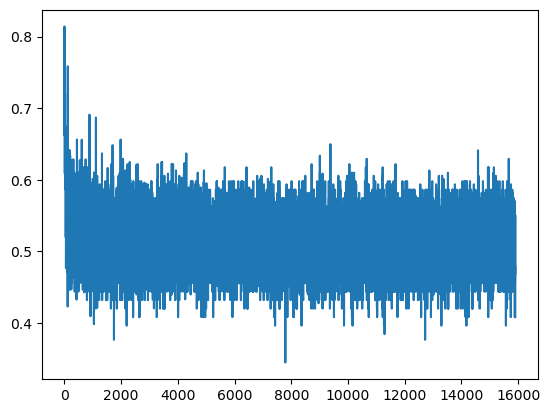

Epoch [100/99], 0.40823306077915805


In [25]:
training_losses = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    model.train()
    
    for input, labels in tqdm(training_iterator):
        labels = labels.unsqueeze(1).to(torch.double).to(device)
        model_optimizer.zero_grad()
        outputs = model(input.to(device))
        loss = criterion(outputs, labels.to(torch.double))
        loss.backward()
        
        training_losses.append(loss.item())
        

        model_optimizer.step()
    
    clear_output(wait=True)
    plt.plot(training_losses)
    plt.show()
    print(f'Epoch [{epoch+1}/{epoch}], {loss.item()}')
    if loss.item() < 0.25:
        break
    

In [26]:
total_correct = 0
total = 0
for inp, labels in valid_iterator:
    total += len(labels)
    output = model(inp.to(device))
    outs = [1 if x >= 0.5 else 0 for x in output]
    for i in range(len(outs)):
        if outs[i] == labels[i]:
            total_correct += 1

print(f"Model accuracy: {total_correct/len(labels):.2f}%")

Model accuracy: 60.63%


In [27]:
torch.save(model.state_dict(), "./model.h5")